In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

file = "emopain_"
mehtod = "srnn"
suffix = "_10sp_0.0dp" # "_old_bszs"
file += mehtod + suffix
data_types = ["emg", "energy", "angle"]
encoders = ["STL-S", "STL-V"]#, "rate", "latency"]

data = []
filenames = []
for data_type in data_types:
    for encoder in encoders:
        # Exception for bsz results for STL-S [32, 8, 16]
        # if encoder == "STL-S":
        #     results = pd.read_csv(f'../results/{file}_bsz/results_{data_type}_{encoder}.csv', index_col=0)
        # else:
        results = pd.read_csv(f'../results/fixmi/{file}/results_{data_type}_{encoder}.csv', index_col=0)
        filenames.append(f"{file} {data_type} {encoder}")
        print(filenames[-1])
        try:
            results.set_index('fold', inplace=True)
        except:
            print('.')
        results.index = results.index.astype(int)
        # deduplicate the fold index
        results = results[~results.index.duplicated(keep='first')]
        try:
            results['test_preds'] = results['test_preds'].apply(lambda x: int(x.strip('[]')))
            results['test_labels'] = results['test_labels'].apply(lambda x: int(x.strip('[]')))
        except:
            results['test_preds'] = results['ts_pred']
            results['test_labels'] = results['ts_label']
            results["test_acc"] = results["ts_acc"]
        print(f'{data_type}_{encoder}: {results.shape}')
        results.sort_index()
        
        data.append(results)

data[0].tail()

emopain_srnn_10sp_0.0dp emg STL-S
emg_STL-S: (46, 6)
emopain_srnn_10sp_0.0dp emg STL-V
emg_STL-V: (46, 6)
emopain_srnn_10sp_0.0dp energy STL-S
energy_STL-S: (46, 6)
emopain_srnn_10sp_0.0dp energy STL-V
energy_STL-V: (32, 6)
emopain_srnn_10sp_0.0dp angle STL-S
angle_STL-S: (12, 6)
emopain_srnn_10sp_0.0dp angle STL-V
.
angle_STL-V: (0, 6)


,train_acc,val_acc,test_acc,test_preds,test_labels,sparsity
fold,,,,,,
41,-1,-1,100.0,0,0,0.446600
42,-1,-1,0.0,0,1,0.378875
43,-1,-1,100.0,0,0,0.445933
44,-1,-1,100.0,0,0,0.348208
45,-1,-1,0.0,0,1,0.368613


In [73]:

results_dict = {}
for i, d in enumerate(data):
    file, data_type, encoder = filenames[i].split(" ")
    filename = f"{file}_{data_type}_{encoder}"
    print(file, data_type, encoder)

    accuracies = d["test_acc"]
    sparsities = d["sparsity"]
    preds = d["test_preds"].to_numpy().flatten()
    labels = d["test_labels"].to_numpy().flatten()
    print(np.mean(accuracies))
    print(np.mean(sparsities))
    
    try:
        results_dict[filename]["accuracies"].append(np.mean(accuracies))
        results_dict[filename]["sparsities"].append(np.mean(sparsities))
        results_dict[filename]["labels"].append(labels)
        results_dict[filename]["preds"].append(preds)
    except:
        results_dict[filename] = {"accuracies": [np.mean(accuracies)],
                                  "sparsities": [np.mean(sparsities)],
                                  "preds": [preds],
                                  "labels": [labels]}


emopain_srnn_10sp_0.5dp emg STL-S
63.04347826086956
0.4158286956521739
emopain_srnn_10sp_0.5dp emg STL-V
63.04347826086956
0.007484528985507216
emopain_srnn_10sp_0.5dp energy STL-S
71.73913043478261
0.6567797826086956
emopain_srnn_10sp_0.5dp energy STL-V
100.0
0.43726327777777774
emopain_srnn_10sp_0.5dp angle STL-S
69.56521739130434
0.6871345289855072
emopain_srnn_10sp_0.5dp angle STL-V
nan
nan


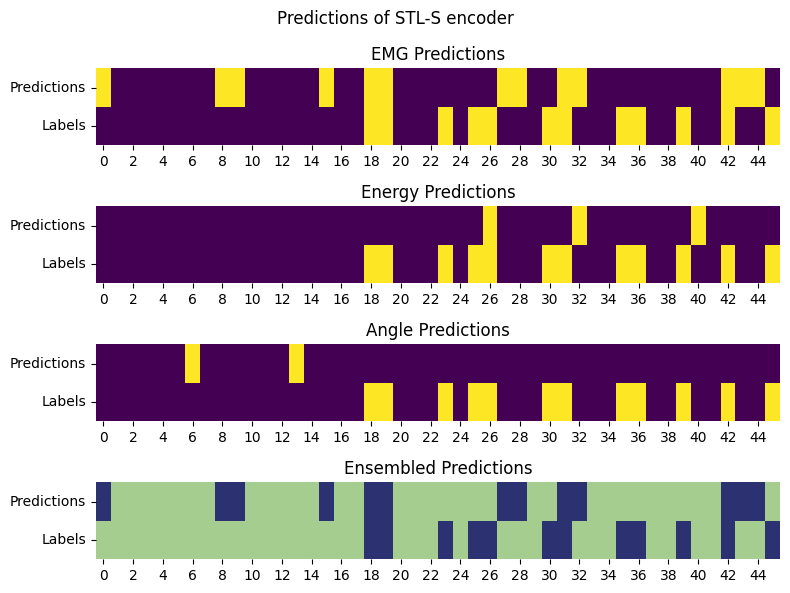

Ensemble Accuracy: 63.04
Ensemble AUC: 0.534
Ensemble F1 Score: 0.320 <- 0.308 & 0.333
Ensemble MCC: 0.067
Harmonic mean sparsity: 0.557 <- 0.416 & 0.657 & 0.687


ValueError: Found input variables with inconsistent numbers of samples: [46, 10]

In [74]:
import seaborn as sns
from sklearn.metrics import accuracy_score, roc_auc_score, auc, precision_recall_curve, f1_score, precision_score, recall_score, matthews_corrcoef
from scipy.stats import hmean

ensemble = {}
ensemble_preds_d = {encoder: [] for encoder in encoders}

for encoder in encoders:
    # Extract predictions and labels
    emg_preds = results_dict[f'{file}_emg_{encoder}']['preds'][0]
    energy_preds = results_dict[f'{file}_energy_{encoder}']['preds'][0]
    angle_preds = results_dict[f'{file}_angle_{encoder}']['preds'][0]
    labels = results_dict[f'{file}_emg_{encoder}']['labels'][0]  # Assuming labels are the same for all data types

    # Calculate accuracy weights
    emg_acc = results_dict[f'{file}_emg_{encoder}']['accuracies'][0]
    energy_acc = results_dict[f'{file}_energy_{encoder}']['accuracies'][0]
    angle_acc = results_dict[f'{file}_angle_{encoder}']['accuracies'][0]
    
    emg_f1 = f1_score(labels, emg_preds)
    energy_f1 = f1_score(labels, energy_preds)
    angle_f1 = f1_score(labels, angle_preds)

    emg_mcc = matthews_corrcoef(labels, emg_preds)
    energy_mcc = matthews_corrcoef(labels, energy_preds)
    angle_mcc = matthews_corrcoef(labels, angle_preds)

    # if mehtod == "svm":
    weights = [emg_f1, energy_f1, angle_f1]
    # if mehtod == "srnn":
    #     weights = [emg_acc, energy_acc, angle_acc]

    # Perform accuracy-weighted majority voting
    ensemble_preds = np.round(
        (emg_preds * weights[0] + energy_preds * weights[1] + angle_preds * weights[2]) / sum(weights)
    ).astype(int)
# Perform non-weighted majority voting
# ensemble_preds = np.round((emg_preds + energy_preds + angle_preds) / 3).astype(int)

    fig, axs = plt.subplots(4, 1, figsize=(8,6))

    sns.heatmap(np.vstack([emg_preds, labels]), ax=axs[0], cbar=False, cmap='viridis')
    axs[0].set_title('EMG Predictions')
    axs[0].set_yticklabels(['Predictions', 'Labels'])
    axs[0].tick_params(axis='y', rotation=0)

    sns.heatmap(np.vstack([energy_preds, labels]), ax=axs[1], cbar=False, cmap='viridis')
    axs[1].set_title('Energy Predictions')
    axs[1].set_yticklabels(['Predictions', 'Labels'])
    axs[1].tick_params(axis='y', rotation=0)

    sns.heatmap(np.vstack([angle_preds, labels]), ax=axs[2], cbar=False, cmap='viridis')
    axs[2].set_title('Angle Predictions')
    axs[2].set_yticklabels(['Predictions', 'Labels'])
    axs[2].tick_params(axis='y', rotation=0)

    sns.heatmap(np.vstack([ensemble_preds, labels]), ax=axs[3], cbar=False, cmap='crest')
    axs[3].set_yticklabels(['Predictions', 'Labels'])
    axs[3].tick_params(axis='y', rotation=0)
    axs[3].set_title('Ensembled Predictions')

    plt.suptitle(f"Predictions of {encoder} encoder")
    plt.tight_layout()
    plt.show()

    # Calculate the harmonic mean sparsity
    sparsities = [
        results_dict[f'{file}_emg_{encoder}']['sparsities'][0],
        results_dict[f'{file}_energy_{encoder}']['sparsities'][0],
        results_dict[f'{file}_angle_{encoder}']['sparsities'][0]
    ]

    harmonic_mean_sparsity = hmean(sparsities)

    # Calculate and print ensemble performance metrics
    ensemble_accuracy = accuracy_score(labels, ensemble_preds)
    # pr_curve = precision_recall_curve(labels, ensemble_preds)
    # ensemble_auc = auc(pr_curve[1], pr_curve[0])
    ensemble_auc = roc_auc_score(labels, ensemble_preds)
    ensemble_f1 = f1_score(labels, ensemble_preds)    
    ensemble_prec = precision_score(labels, ensemble_preds)
    ensemble_rec = recall_score(labels, ensemble_preds)
    ensemble_mcc = matthews_corrcoef(labels, ensemble_preds)

    print(f'Ensemble Accuracy: {ensemble_accuracy*100:.2f}')
    print(f'Ensemble AUC: {ensemble_auc:.3f}')
    print(f'Ensemble F1 Score: {ensemble_f1:.3f} <- {ensemble_prec:.3f} & {ensemble_rec:.3f}')
    print(f'Ensemble MCC: {ensemble_mcc:.3f}')
    print(f'Harmonic mean sparsity: {harmonic_mean_sparsity:.3f} <- {" & ".join([f"{s:.3f}" for s in sparsities])}')
    
    ensemble[encoder] = [ensemble_accuracy, ensemble_auc, ensemble_f1, ensemble_mcc, harmonic_mean_sparsity]
    
    encoder_preds = ensemble_preds.tolist()  # Convert for clarity (optional)
    ensemble_preds_d[encoder].append(encoder_preds)  # Append current predictions list
    ensemble_preds_d["labels"] = labels.tolist()  # Add labels to the dictionary
    

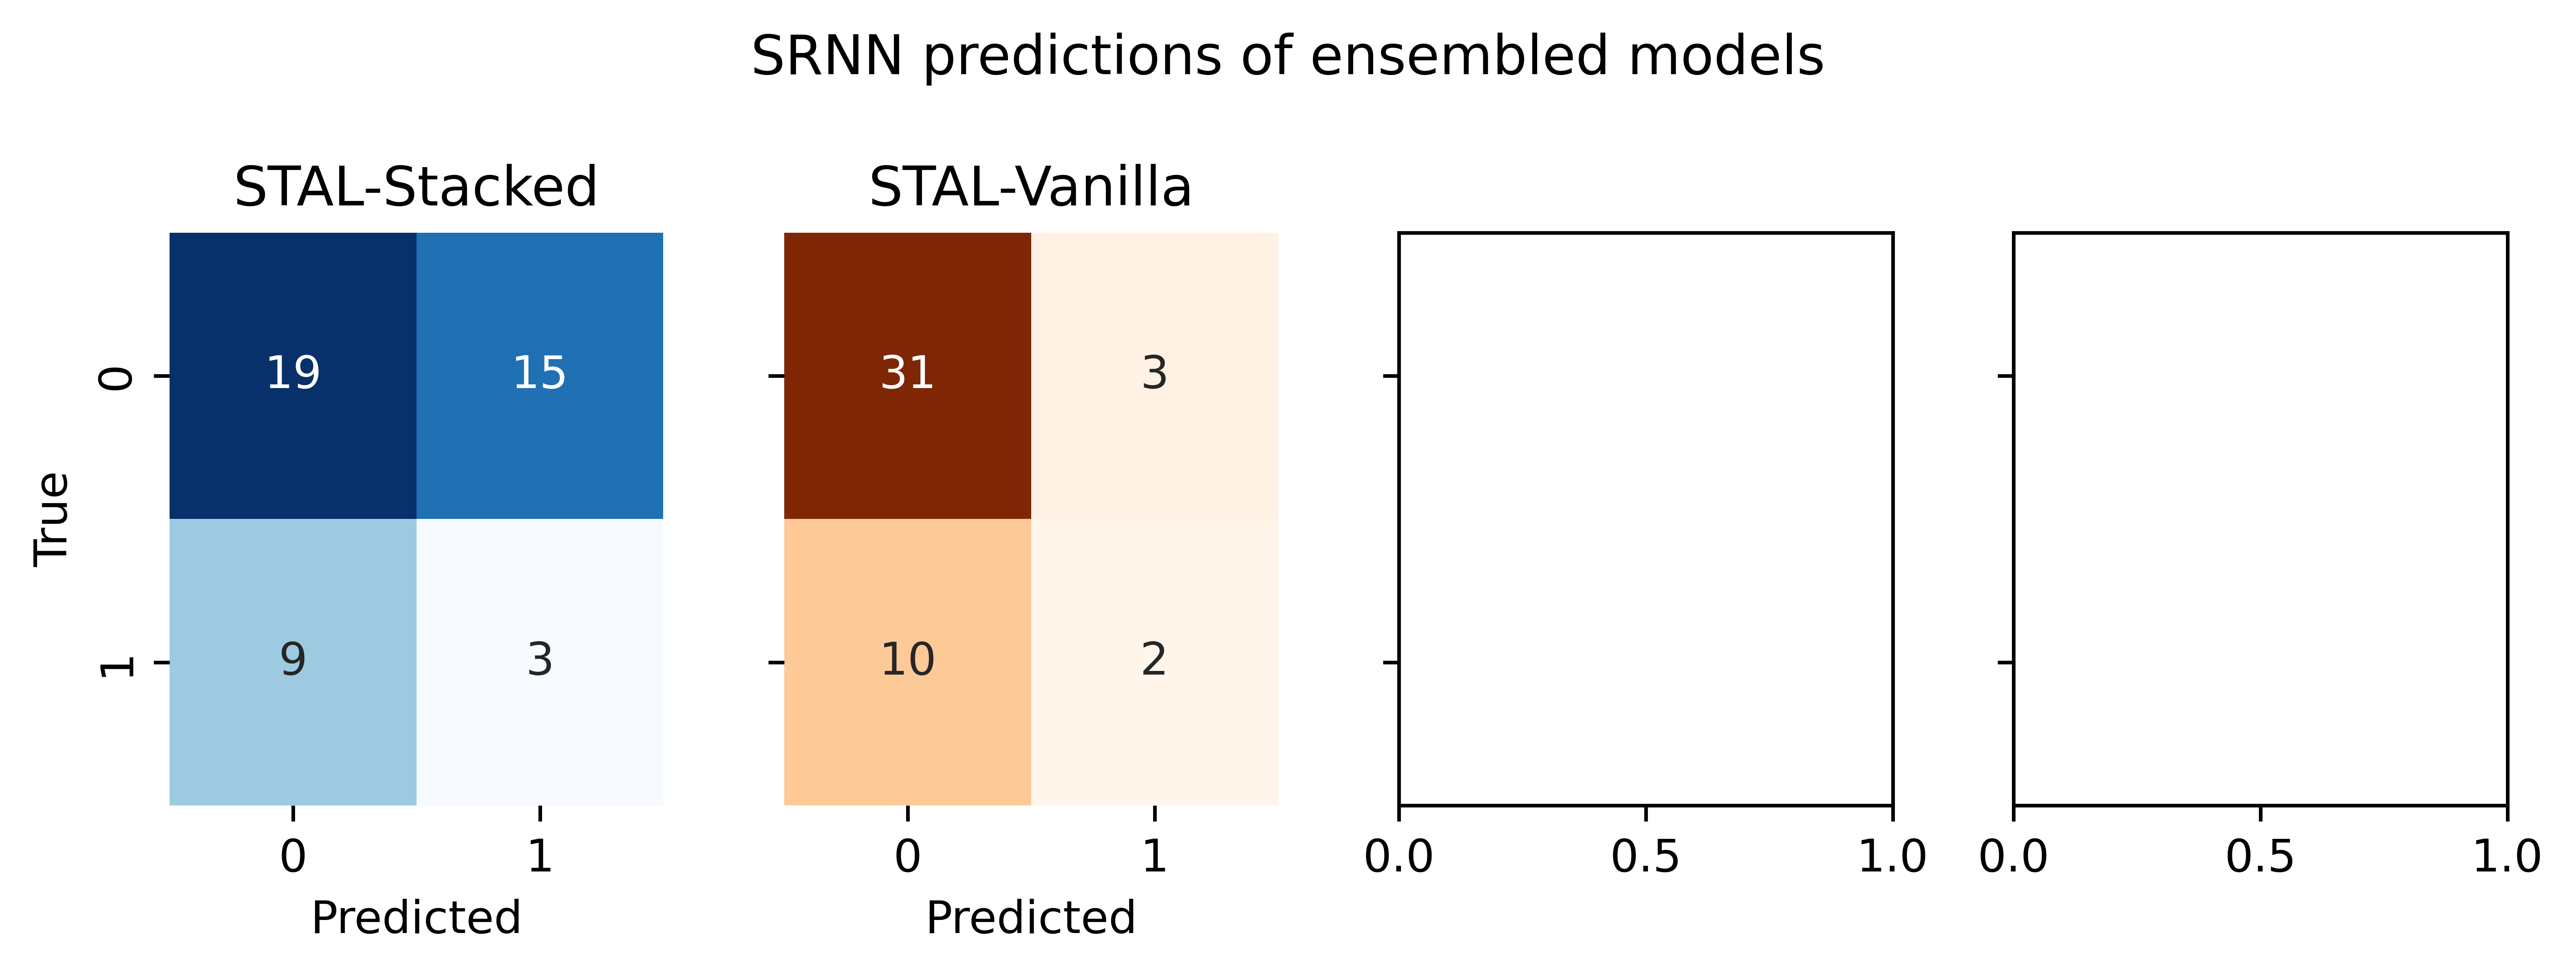

In [ ]:
from sklearn.metrics import confusion_matrix

fig, axs = plt.subplots(1, 4, figsize=(8, 3), sharey=True, dpi=800)

encoders = ["STL-S", "STL-V"] #, "rate", "latency"]
colors = ['Blues', 'Oranges', 'Greens', 'Reds']

for i, encoder in enumerate(encoders):
    # Plot confusion matrices
    labels = ensemble_preds_d["labels"]
    cm = confusion_matrix(labels, ensemble_preds_d[encoder][0])
    if encoder=="STL-V": encoder = "STAL-Vanilla"
    if encoder=="STL-S": encoder = "STAL-Stacked"
    if encoder=="rate": encoder = "Rate-coding"
    if encoder=="latency": encoder = "Latency-coding"
    sns.heatmap(cm, ax=axs[i], cbar=False, cmap=colors[i], annot=True, fmt='d')
    axs[i].set_title(f'{encoder}')
    axs[i].set_xlabel('Predicted')
    if i==0:
        axs[i].set_ylabel('True')
plt.suptitle(f"{mehtod.upper()} predictions of ensembled models")
plt.tight_layout()
plt.show()

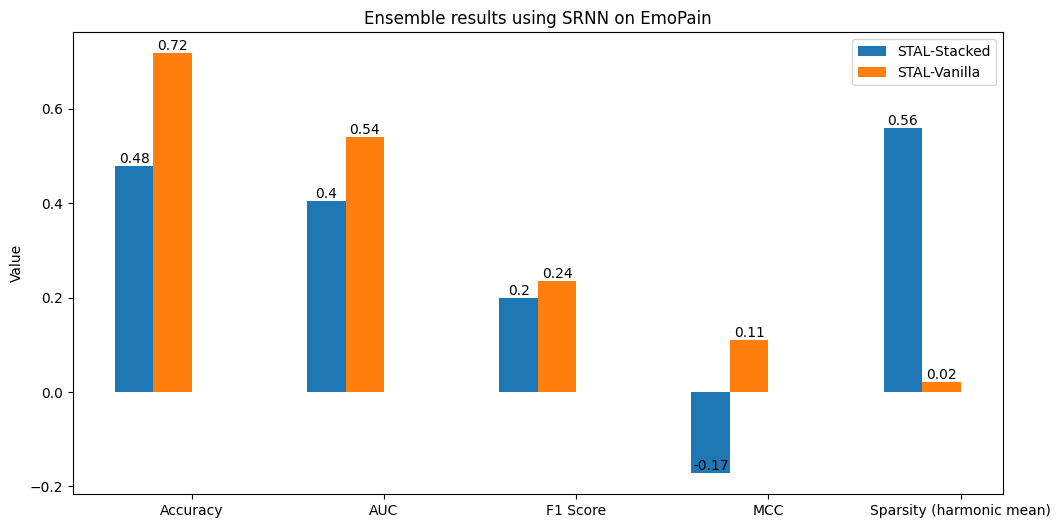

In [ ]:
labels = list(ensemble.keys())
values = np.array(list(ensemble.values()))

x = np.arange(values.shape[1])
width = 0.2

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

fig, ax = plt.subplots(figsize=(12, 6))

for i, (key, values) in enumerate(ensemble.items()):
    if key == "STL-S": key = "STAL-Stacked"
    if key == "STL-V": key = "STAL-Vanilla"
    if key == "rate": key = "Rate-coding"
    if key == "latency": key = "Latency-coding"
    bars = ax.bar(x + i * width, values, width, label=key, color=colors[i])
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), 
                va='bottom', ha='center')

ax.set_ylabel('Value')
ax.set_title(f'Ensemble results using {mehtod.upper()} on EmoPain')
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(["Accuracy", "AUC", "F1 Score", "MCC", "Sparsity (harmonic mean)"])
ax.legend()

plt.show()


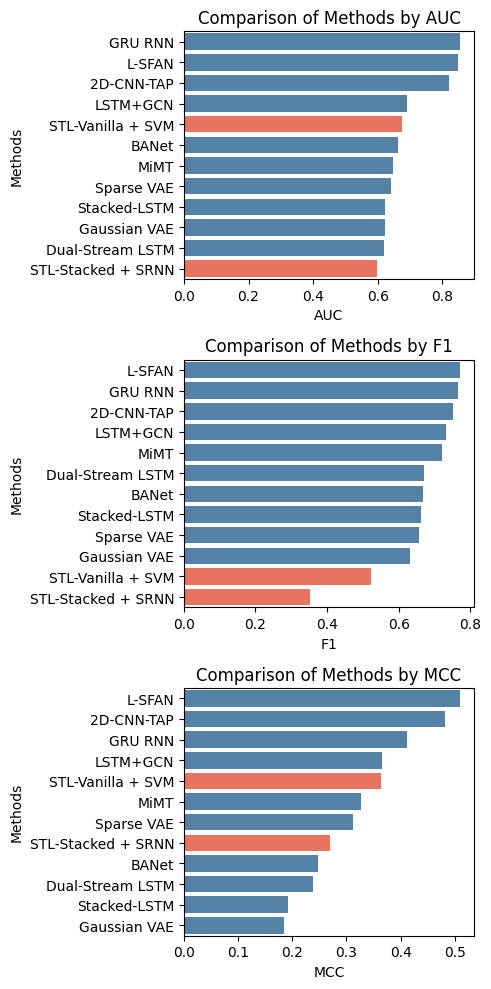

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Data
methods = [
    'Stacked-LSTM', 'Dual-Stream LSTM', 'BANet', 'MiMT', 'LSTM+GCN', 
    'Sparse VAE', 'Gaussian VAE', 'GRU RNN', '2D-CNN-TAP', 'L-SFAN',
    'STL-Vanilla + SVM', 'STL-Stacked + SRNN'
]
auc = [0.622, 0.618, 0.663, 0.648, 0.690, 0.641, 0.622, 0.855, 0.819, 0.849, 0.676, 0.596]
f1 = [0.662, 0.671, 0.668, 0.722, 0.731, 0.658, 0.631, 0.765, 0.752, 0.772, 0.522, 0.353]
mcc = [0.192, 0.238, 0.247, 0.327, 0.365, 0.312, 0.185, 0.411, 0.481, 0.510, 0.363, 0.270]

# DataFrame
df = pd.DataFrame({
    'Methods': methods,
    'AUC': auc,
    'F1': f1,
    'MCC': mcc
})

# Plotting function
def plot_metric(ax, metric, title, highlight):
    sorted_df = df.sort_values(by=metric, ascending=False)
    colors = ['#FF6347' if m in highlight else '#4682B4' for m in sorted_df['Methods']]
    
    sns.barplot(ax=ax, x=sorted_df[metric], y=sorted_df['Methods'], hue=sorted_df["Methods"], palette=colors)
    ax.set_title(title)
    ax.set_xlabel(metric)
    ax.set_ylabel('Methods')

# Highlight proposed methods
highlight = ['STL-Vanilla + SVM', 'STL-Stacked + SRNN']

# Create subplots
fig, axes = plt.subplots(3, 1, figsize=(5, 10))

# Plot each metric
plot_metric(axes[0], 'AUC', 'Comparison of Methods by AUC', highlight)
plot_metric(axes[1], 'F1', 'Comparison of Methods by F1', highlight)
plot_metric(axes[2], 'MCC', 'Comparison of Methods by MCC', highlight)

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

spikes = [2, 5, 10, 15] #, 20, 30]

data = []
filenames = []
for i_spikes in spikes:
    file = "emopain_"
    mehtod = "svm"
    suffix = f"_{i_spikes}sp" # ""
    # if i_spikes == 10: suffix = ""
    # if i_spikes==5: suffix += "_mi"
    file += mehtod + suffix
    data_types = ["emg", "energy", "angle"]
    encoders = ["STL-V", "STL-S", "rate", "latency"]

   
    for data_type in data_types:
        for encoder in encoders:
            # Exception for bsz results for STL-S [32, 8, 16]
            # if encoder == "STL-S":
            #     results = pd.read_csv(f'../results/{file}_bsz/results_{data_type}_{encoder}.csv', index_col=0)
            # else:
            results = pd.read_csv(f'../results/fixmi/{file}/results_{data_type}_{encoder}.csv', index_col=0)
            filenames.append(f"{file} {data_type} {encoder}")

            try:
                results.set_index('fold', inplace=True)
            except:
                print('.')
            results.dropna(inplace=True)
            results.index = results.index.astype(int)
            # deduplicate the fold index
            results = results[~results.index.duplicated(keep='first')]
            try:
                results['test_preds'] = results['test_preds'].apply(lambda x: int(x.strip('[]')))
                results['test_labels'] = results['test_labels'].apply(lambda x: int(x.strip('[]')))
            except:
                results['test_preds'] = results['ts_pred']
                results['test_labels'] = results['ts_label']
                results["test_acc"] = results["ts_acc"]
            print(f'{data_type}_{encoder}: {results.shape}')
            results.sort_index()
            
            if results.shape[0] == 47:
                print(filenames[-1], "not of correct shape:", results.shape)
            data.append(results)

emg_STL-V: (46, 6)
emg_STL-S: (46, 6)
emg_rate: (46, 6)
emg_latency: (46, 6)
energy_STL-V: (46, 6)
energy_STL-S: (46, 6)
energy_rate: (46, 6)
energy_latency: (46, 6)
angle_STL-V: (46, 6)
angle_STL-S: (46, 6)
angle_rate: (46, 6)
angle_latency: (46, 6)
emg_STL-V: (46, 6)
emg_STL-S: (46, 6)
emg_rate: (46, 6)
emg_latency: (46, 6)
energy_STL-V: (46, 6)
energy_STL-S: (46, 6)
energy_rate: (46, 6)
energy_latency: (46, 6)
angle_STL-V: (46, 6)
angle_STL-S: (46, 6)
angle_rate: (46, 6)
angle_latency: (46, 6)
emg_STL-V: (46, 6)
emg_STL-S: (46, 6)
emg_rate: (46, 6)
emg_latency: (46, 6)
energy_STL-V: (46, 6)
energy_STL-S: (46, 6)
energy_rate: (46, 6)
energy_latency: (46, 6)
angle_STL-V: (46, 6)
angle_STL-S: (46, 6)
angle_rate: (46, 6)
angle_latency: (46, 6)
emg_STL-V: (46, 6)
emg_STL-S: (46, 6)
emg_rate: (46, 6)
emg_latency: (46, 6)
energy_STL-V: (46, 6)
energy_STL-S: (46, 6)
energy_rate: (46, 6)
energy_latency: (46, 6)
angle_STL-V: (46, 6)
angle_STL-S: (46, 6)
angle_rate: (46, 6)
angle_latency: (46,

In [ ]:
results_dict = {}
for i, d in enumerate(data):
    file, data_type, encoder = filenames[i].split(" ")
    filename = f"{file}_{data_type}_{encoder}"
    print(file, data_type, encoder)

    accuracies = d["test_acc"]
    sparsities = d["sparsity"]
    preds = d["test_preds"].to_numpy().flatten()
    labels = d["test_labels"].to_numpy().flatten()
    print(np.mean(accuracies))
    print(np.mean(sparsities))
    
    try:
        results_dict[filename]["accuracies"].append(np.mean(accuracies))
        results_dict[filename]["sparsities"].append(np.mean(sparsities))
        results_dict[filename]["labels"].append(labels)
        results_dict[filename]["preds"].append(preds)
    except:
        results_dict[filename] = {"accuracies": [np.mean(accuracies)],
                                "sparsities": [np.mean(sparsities)],
                                "preds": [preds],
                                "labels": [labels]}

emopain_svm_2sp emg STL-V
69.56521739130434
0.0073556159420289586
emopain_svm_2sp emg STL-S
26.08695652173913
0.2588005434782608
emopain_svm_2sp emg rate
69.56521739130434
0.06827391304347823
emopain_svm_2sp emg latency
28.26086956521739
0.5
emopain_svm_2sp energy STL-V
54.34782608695652
0.43661086956521744
emopain_svm_2sp energy STL-S
36.95652173913044
0.6734054347826087
emopain_svm_2sp energy rate
50.0
0.5835679347826087
emopain_svm_2sp energy latency
71.73913043478261
0.5
emopain_svm_2sp angle STL-V
52.17391304347826
0.5263051932367148
emopain_svm_2sp angle STL-S
30.434782608695652
0.7887285628019325
emopain_svm_2sp angle rate
60.869565217391305
0.7027927536231885
emopain_svm_2sp angle latency
32.608695652173914
0.5
emopain_svm_5sp emg STL-V
65.21739130434783
0.0074063768115941635
emopain_svm_5sp emg STL-S
28.26086956521739
0.2264953623188406
emopain_svm_5sp emg rate
65.21739130434783
0.06815869565217388
emopain_svm_5sp emg latency
65.21739130434783
0.1999999999999999
emopain_svm_5s

In [ ]:
# Extract data
encoders = ["STL-V", "STL-S", "rate"]#, "latency"]
accuracies = {encoder: [] for encoder in encoders}
f1s = {encoder: [] for encoder in encoders}
mccs = {encoder: [] for encoder in encoders}
aucs = {encoder: [] for encoder in encoders}
sparsities = {encoder: [] for encoder in encoders}

file = "emopain_svm"
for sp in spikes:
    for encoder in encoders:
        # Extract predictions and labels
        spikes_part = f"_{sp}sp"
        # if sp == 10: spikes_part = ""
        # if sp == 5: spikes_part += "_mi"
        
        emg_preds = results_dict[f'{file}{spikes_part}_emg_{encoder}']['preds'][0]
        emg_spars = results_dict[f'{file}{spikes_part}_emg_{encoder}']['sparsities'][0]
        energy_preds = results_dict[f'{file}{spikes_part}_energy_{encoder}']['preds'][0]
        energy_spars = results_dict[f'{file}{spikes_part}_energy_{encoder}']['sparsities'][0]
        angle_preds = results_dict[f'{file}{spikes_part}_angle_{encoder}']['preds'][0]
        angle_spars = results_dict[f'{file}{spikes_part}_angle_{encoder}']['sparsities'][0]
        labels = results_dict[f'{file}{spikes_part}_emg_{encoder}']['labels'][0]  # Assuming labels are the same for all data types

        # Calculate accuracy weights
        emg_acc = results_dict[f'{file}{spikes_part}_emg_{encoder}']['accuracies'][0]
        energy_acc = results_dict[f'{file}{spikes_part}_energy_{encoder}']['accuracies'][0]
        angle_acc = results_dict[f'{file}{spikes_part}_angle_{encoder}']['accuracies'][0]
        
        try:
            emg_f1 = f1_score(labels, emg_preds)
            energy_f1 = f1_score(labels, energy_preds)
            angle_f1 = f1_score(labels, angle_preds)
            
            emg_mcc = matthews_corrcoef(labels, emg_preds)
            energy_mcc = matthews_corrcoef(labels, energy_preds)
            angle_mcc = matthews_corrcoef(labels, angle_preds)
        except:
            emg_f1 = 0
            energy_f1 = 0
            angle_f1 = 0
            
            emg_mcc = 0
            energy_mcc = 0
            angle_mcc = 0

        weights = [emg_f1, energy_f1, angle_f1]
        weights = [1, 1, 1]

        # Perform accuracy-weighted majority voting
        try:
            ensemble_preds = np.round(
                (emg_preds * weights[0] + energy_preds * weights[1] + angle_preds * weights[2]) / sum(weights)
            ).astype(int)
        
            accuracies[encoder].append(accuracy_score(labels, ensemble_preds))
            f1s[encoder].append(f1_score(labels, ensemble_preds))
            mccs[encoder].append(matthews_corrcoef(labels, ensemble_preds))
            aucs[encoder].append(roc_auc_score(labels, ensemble_preds))
            sparsities[encoder].append(hmean([emg_spars, energy_spars, angle_spars]))
        except:
            accuracies[encoder].append(np.nan)
            f1s[encoder].append(np.nan)
            mccs[encoder].append(np.nan)
            aucs[encoder].append(np.nan)
            sparsities[encoder].append(np.nan)

# different markers
markers = ['o', 's', 'D', '^']
# different linestyles
linestyles = ['-', '--', '-.', ':']

enc_names = {"STL-V": "STAL-Vanilla", "STL-S": "STAL-Stacked", "rate": "Rate-coding", "latency": "Latency-coding"}

# Plot
fix, axs = plt.subplots(1, 5, figsize=(20, 4), dpi=800)

for m, encoder in enumerate(encoders):
    axs[0].plot(spikes, accuracies[encoder], marker=markers[m], linestyle=linestyles[m], label=enc_names[encoder])

axs[0].set_xlabel(r'$\psi$, number of spikes per time step')
axs[0].set_ylabel('Accuracy')
axs[0].set_title('Accuracy')
axs[0].legend()
axs[0].grid(True)
axs[0].set_xticks(spikes)

for m, encoder in enumerate(encoders):
    axs[1].plot(spikes, f1s[encoder], marker=markers[m], linestyle=linestyles[m], label=enc_names[encoder])

axs[1].set_xlabel(r'$\psi$, number of spikes per time step')
axs[1].set_ylabel('F1')
axs[1].set_title('F1')
# axs[1].legend()
axs[1].grid(True)
axs[1].set_xticks(spikes)

for m, encoder in enumerate(encoders):
    axs[2].plot(spikes, aucs[encoder], marker=markers[m], linestyle=linestyles[m], label=enc_names[encoder])

axs[2].set_xlabel(r'$\psi$, number of spikes per time step')
axs[2].set_ylabel('AUC')
axs[2].set_title('AUC')
# axs[2].legend()
axs[2].grid(True)
axs[2].set_xticks(spikes)

for m, encoder in enumerate(encoders):
    axs[3].plot(spikes, mccs[encoder], marker=markers[m], linestyle=linestyles[m], label=enc_names[encoder])

axs[3].set_xlabel(r'$\psi$, number of spikes per time step')
axs[3].set_ylabel('MCC')
axs[3].set_title('MCC')
# axs[3].legend()
axs[3].grid(True)
axs[3].set_xticks(spikes)

for m, encoder in enumerate(encoders):
    axs[4].plot(spikes, sparsities[encoder], marker=markers[m], linestyle=linestyles[m], label=enc_names[encoder])

axs[4].set_xlabel(r'$\psi$, number of spikes per time step')
axs[4].set_ylabel('Spike Density (harmonic mean)')
axs[4].set_title('Spike Density')
# axs[4].legend()
axs[4].grid(True)
axs[4].set_xticks(spikes)

handles, labels = axs[2].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.95), ncol=len(methods))

plt.suptitle(r"Metrics of SVM for varying $\psi$")
plt.tight_layout()
plt.show()